In [1]:
import pandas
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt, mpld3
import lowry
Q_ = lowry.ureg.Quantity

In [2]:
gdf = geopandas.read_file("tmp/n761s-acceleration.gpx", layer='track_points')
gdf = gdf[['ele','time','geometry']]
gdf

,ele,time,geometry
0,0.000,2022-12-07 19:05:55.708000+00:00,POINT (-122.11216 37.45716)
1,0.000,2022-12-07 19:05:56.617000+00:00,POINT (-122.11216 37.45716)
2,-1.524,2022-12-07 19:05:57.621000+00:00,POINT (-122.11216 37.45716)
3,0.000,2022-12-07 19:05:58.691000+00:00,POINT (-122.11216 37.45716)
4,0.000,2022-12-07 19:05:59.674000+00:00,POINT (-122.11216 37.45716)
...,...,...,...
3736,10.668,2022-12-07 20:17:22.352000+00:00,POINT (-122.11409 37.45799)
3737,10.668,2022-12-07 20:17:23.382000+00:00,POINT (-122.11409 37.45795)
3738,10.668,2022-12-07 20:17:25.351000+00:00,POINT (-122.11409 37.45791)
3739,10.668,2022-12-07 20:17:26.352000+00:00,POINT (-122.11409 37.45780)


In [3]:
gdf['ele_ft'] = gdf.ele.transform(lambda x: Q_(x, 'meter').m_as('ft'))
gdf['geometry_utm'] = gdf.geometry.to_crs(gdf.geometry.estimate_utm_crs())

In [9]:
# this might be overkill, looks like diff() gives essentially the same answer, but just in case each sample is not sufficiently close to 1.0 second apart
def derivative(df):
    index = df.index
    if isinstance(index, pandas.DatetimeIndex):
        den = index.to_series(keep_tz=True).diff().dt.total_seconds()
    else:
        den = index.to_series().diff()
    num = df.diff()
    return num.div(den, axis=0)


In [10]:
# identify run start/end times in foreflight or google earth
runs_times = [
    ["2022-12-07T19:21:50Z", "2022-12-07T19:22:32Z"],
    ["2022-12-07T19:25:22Z", "2022-12-07T19:26:06Z"],
    ["2022-12-07T19:31:32Z", "2022-12-07T19:32:15Z"],
    ["2022-12-07T19:34:48Z", "2022-12-07T19:35:30Z"]]

runs = [gdf[gdf.time.between(a,b)] for a,b in runs_times]
run = runs[2]

(0.0, 5400.0)

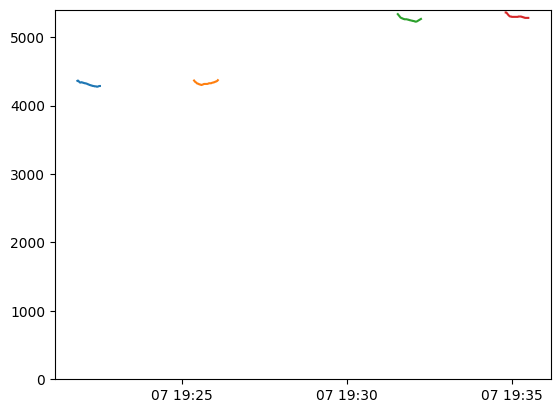

In [12]:
# they look flat-ish? they're +/- 50 so probably ok but I think the area of interest is right near the beginning where things are changing the most (diving a bit)
# I wonder if I could use a much lower power setting and still get Vx - things would move slower.
fig, ax = plt.subplots()
for r in runs:
    ax.plot(r.time, r.ele_ft)
ax.set_ylim([0,5400])

Well, ForeFlight's elevation data is quantized to 5 feet and what's more, some lat/lon are the same sometimes even for several samples (e.g. 4 samples in a row starting at `2022-12-07T19:32:16.358752965Z`). So perhaps we can't much count on GPS data though we could filter and interpolate it wouldn't be much good more granular than about 10s.

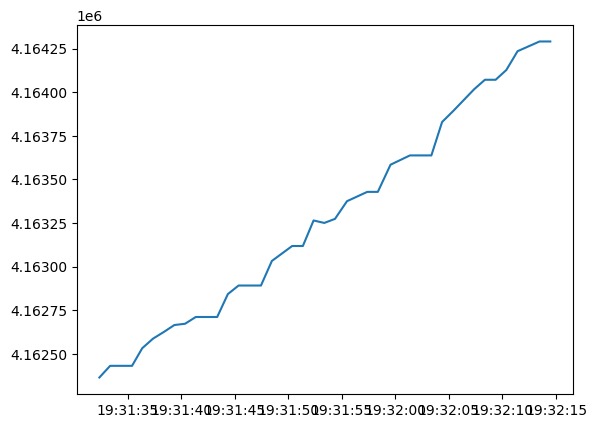

In [7]:
p0 = run.iloc[0].geometry
distance_from_p0 = run.geometry_utm.distance(p0)

fig, ax = plt.subplots()
ax.plot(run.time, distance_from_p0)

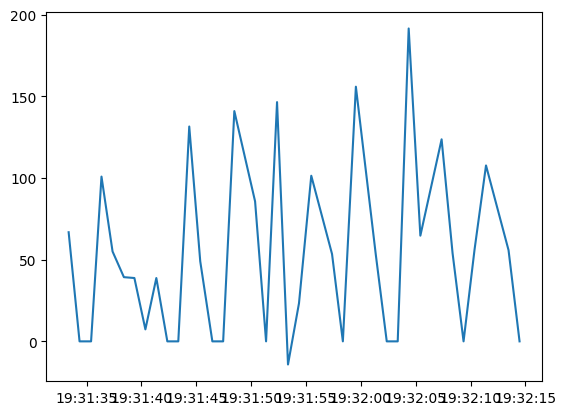

In [8]:
fig, ax = plt.subplots()
ax.plot(run.time, derivative(distance_from_p0))